In [1]:
import os
import datetime
import time

import geopandas as gp
import numpy as np
import pandas as pd
import rsfuncs as rs

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from itertools import combinations

from matplotlib.lines import Line2D
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from dateutil.relativedelta import relativedelta
from shapely.ops import unary_union
from pandas.plotting import register_matplotlib_converters
from shapely.ops import unary_union
from pandas.tseries.offsets import MonthEnd

register_matplotlib_converters()

In [2]:
catchments = gp.read_file("../shape/sierra_catchments.shp")

In [3]:
data_dir = "../data/RS_catchdat/"
files = [os.path.join(data_dir,x) for x in os.listdir(data_dir)]

In [5]:
dfdict = {x[-6:-4]:pd.read_csv(x) for x in files}

dfs = {}
for k,v in dfdict.items():
    if not k.isnumeric():
        idx = int(k[-1:])
        dfs[idx] = v
    else:
        idx = int(k)
        dfs[idx] = v

CALAVERAS R 1126.71


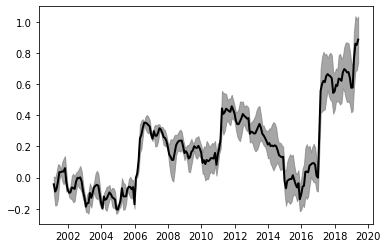

MERCED R 3215.7486


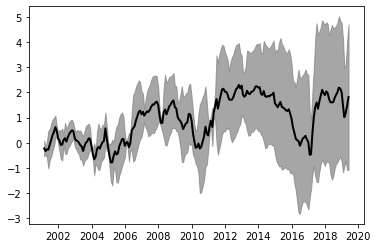

COSUMNES 1672.7633999999998


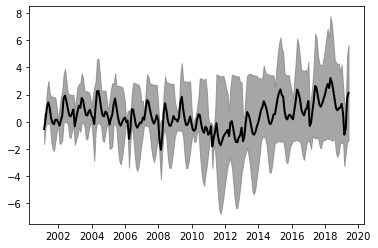

KAWEAH R 1954.9593


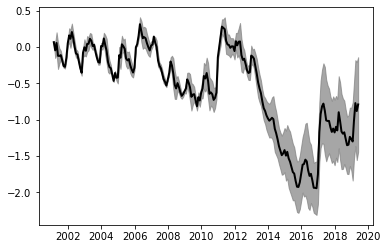

KERN R 6221.0511


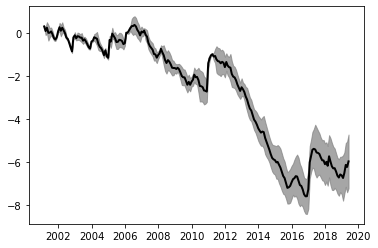

YUBA R 3495.3687


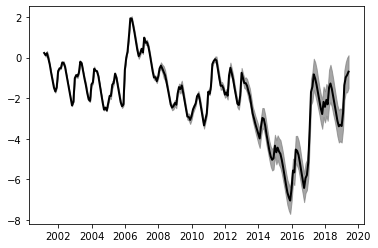

KINGS R 4702.4793


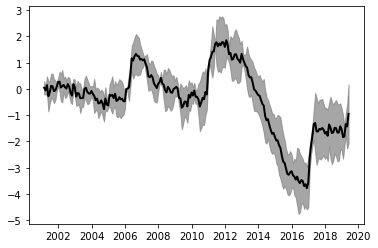

MOKELUMNE R 1771.0973999999999


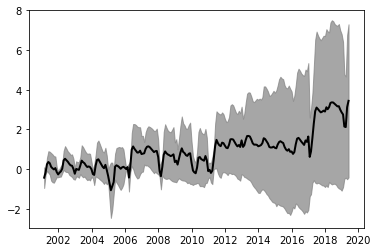

STANISLAUS R 2801.79


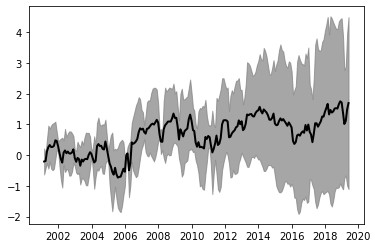

FEATHER R 11426.2893


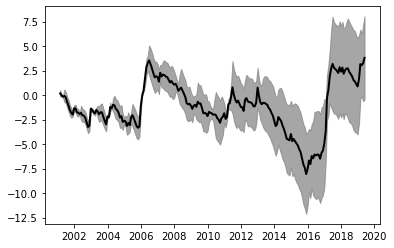

SAN JOAQUIN R 5003.086499999999


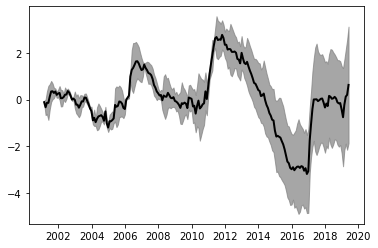

AMERICAN R 5838.2532


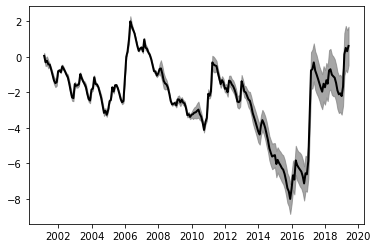

BEAR R 887.0472


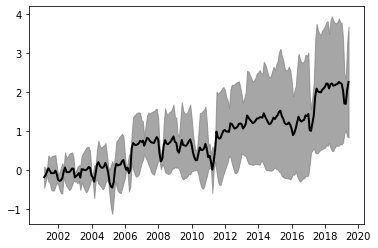

TUOLUMNE R 4722.405299999999


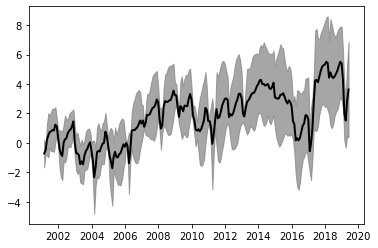

SACRAMENTO R 24146.043299999998


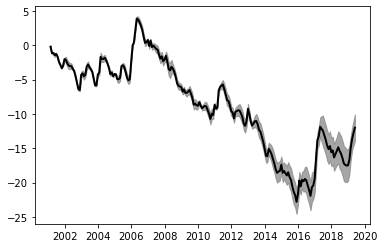

TULE R 1182.0492


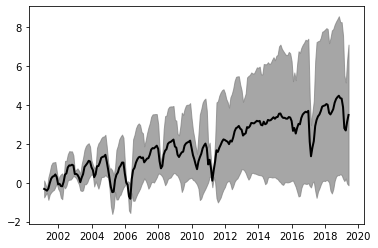

In [7]:
dsdf_list = []
dsdf_dict = {}

for k,v in dfs.items():
    catch = catchments.iloc[k]
    print(catch.catch_name, catch.area_km2)
    df = rs.col_to_dt(v)
    
    if 'Sres_outlet' in df.columns:
        outflow = df['Sres_outlet'].diff()
    else:
        outflow = df['qout_km3']
    
    # Remove first 4 years of data - no MODIS ET 
    adf = df[48:-8]
    
    # Compute an ensemble estimate for dS using MODIS ET, SSEBop ET, LRM SWE, Daymet SWE 
    adf.loc[:, ('ds1')] = adf['p_prism'] - adf['aet_modis'] - adf['swe_lrm'].diff() - adf['tc_sm'].diff() -  adf['Sres'].diff() - outflow
    adf.loc[:, ('ds2')] = adf['p_prism'] - adf['aet_modis'] - adf['dmet_swe'].diff() - adf['tc_sm'].diff() -  adf['Sres'].diff() - outflow
    adf.loc[:, ('ds3')] = adf['p_prism'] - adf['aet_ssebop'] - adf['swe_lrm'].diff() - adf['tc_sm'].diff() -  adf['Sres'].diff() - outflow
    adf.loc[:, ('ds4')] = adf['p_prism'] - adf['aet_ssebop'] - adf['dmet_swe'].diff() - adf['tc_sm'].diff() -  adf['Sres'].diff() - outflow
    
    # Since we computed differentials (.diff()), drop the first row
    adf = adf[1:]
    
    # Difference from 5 year baseline 
    ds1 = np.cumsum(adf['ds1'] - np.mean(adf['ds1'][:60]))
    ds2 = np.cumsum(adf['ds2'] - np.mean(adf['ds2'][:60]))
    ds3 = np.cumsum(adf['ds3'] - np.mean(adf['ds3'][:60]))
    ds4 = np.cumsum(adf['ds4'] - np.mean(adf['ds4'][:60]))
    
    # Get upper and lower bounds 
    dsdf = rs.col_to_dt(pd.DataFrame([ds1.index, 
                                      np.nanmin([ds1,ds2,ds3,ds4], axis = 0).astype(float), 
                                      np.nanmean([ds1,ds2,ds3,ds4], axis = 0).astype(float), 
                                      np.nanmax([ds1,ds2,ds3,ds4], axis = 0).astype(float)]).T)

    # Rename out cols 
    dsdf.columns = ['ds_min', 'ds_mean', 'ds_max']
    
    # Append to out list 
    dsdf_list.append(dsdf)
    dsdf_dict[catch.catch_name] = dsdf
    
    # Plot ds for each wshed 
    plt.plot(dsdf['ds_mean'], color = 'black',  linewidth=2, label = 'ds mean')
    plt.fill_between(dsdf.index, dsdf['ds_min'].astype(float), dsdf['ds_max'].astype(float), color = 'gray', alpha = 0.7, label = 'ds range')
    
    plt.show()


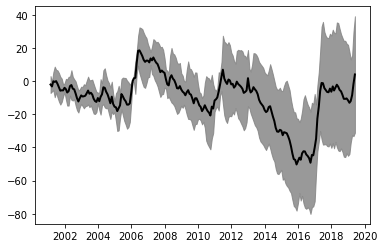

In [8]:
net_ds = np.sum([x['ds_mean'].values for x in dsdf_list], axis = 0)
net_ds_max = np.sum([x['ds_max'].values for x in dsdf_list], axis = 0)
net_ds_min = np.sum([x['ds_min'].values for x in dsdf_list], axis = 0)



plt.plot(dsdf_list[0].index, net_ds, color = 'black', linewidth = 2)
plt.fill_between(dsdf_list[0].index, net_ds_min.astype(float),net_ds_max.astype(float), color = 'gray', alpha = 0.8)
